In [1]:
### Imports ###
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.engine.topology import Network
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

Using TensorFlow backend.


In [2]:
### Constants ###
DATA_DIR = "F:/Mine/MTECH DISSERTATION DOCUMENTS/DATASET COLLECTIONS/Dataset used in project/sky-doc_dataset"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)

In [3]:
DATA_DIR

'F:/Mine/MTECH DISSERTATION DOCUMENTS/DATASET COLLECTIONS/Dataset used in project/sky-doc_dataset'

In [4]:
TRAIN_DIR

'F:/Mine/MTECH DISSERTATION DOCUMENTS/DATASET COLLECTIONS/Dataset used in project/sky-doc_dataset\\train'

In [5]:
TEST_DIR

'F:/Mine/MTECH DISSERTATION DOCUMENTS/DATASET COLLECTIONS/Dataset used in project/sky-doc_dataset\\test'

In [6]:
def load_dataset_small(num_images_train_cover=1000, num_images_train_secret=1000):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train_cover = []
    X_train_secret = []
    
    # Create training set.
    train_dir_cover = os.path.join(TRAIN_DIR, 'cover')
    train_imgs_c = os.listdir(train_dir_cover)
    random.shuffle(train_imgs_c)
    for img_name_i in train_imgs_c[0:num_images_train_cover]:
        img_i = image.load_img(os.path.join(train_dir_cover, img_name_i))
        x = image.img_to_array(img_i)
        X_train_cover.append(x)

    
    # Create test set.
    train_dir_secret = os.path.join(TRAIN_DIR, 'secret')
    train_imgs_s = os.listdir(train_dir_secret)
    random.shuffle(train_imgs_s)
    for img_name_i in train_imgs_s[0:num_images_train_secret]:
        img_i = image.load_img(os.path.join(train_dir_secret, img_name_i))
        x = image.img_to_array(img_i)
        X_train_secret.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train_cover), np.array(X_train_secret)

In [7]:
# Load dataset.
X_train_orig_c, X_train_orig_s = load_dataset_small()

# Normalize image vectors.
X_train_c = X_train_orig_c/255.
X_train_s = X_train_orig_s/255.

# Print statistics.
print ("Number of training cover examples = " + str(X_train_c.shape[0]))
print ("Number of training secret examples = " + str(X_train_s.shape[0]))
#print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training cover examples = 1000
Number of training secret examples = 1000


In [8]:
def load_dataset_small_test(num_images_test_cover=250, num_images_test_secret=250):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_test_cover = []
    X_test_secret = []
    
    # Create training set.
    test_dir_cover = os.path.join(TEST_DIR, 'cover')
    test_imgs_c = os.listdir(test_dir_cover)
    random.shuffle(test_imgs_c)
    for img_name_i in test_imgs_c[0:num_images_test_cover]:
        img_i = image.load_img(os.path.join(test_dir_cover, img_name_i))
        x = image.img_to_array(img_i)
        X_test_cover.append(x)

    
    # Create test set.
    test_dir_secret = os.path.join(TEST_DIR, 'secret')
    test_imgs_s = os.listdir(test_dir_secret)
    random.shuffle(test_imgs_s)
    for img_name_i in test_imgs_s[0:num_images_test_secret]:
        img_i = image.load_img(os.path.join(test_dir_secret, img_name_i))
        x = image.img_to_array(img_i)
        X_test_secret.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_test_cover), np.array(X_test_secret)

In [9]:
# Load dataset.
X_test_orig_c, X_test_orig_s = load_dataset_small_test()

# Normalize image vectors.
X_test_c = X_test_orig_c/255.
X_test_s = X_test_orig_s/255.

# Print statistics.
print ("Number of testing cover examples = " + str(X_test_c.shape[0]))
print ("Number of testing secret examples = " + str(X_test_s.shape[0]))

Number of testing cover examples = 250
Number of testing secret examples = 250


In [10]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.

# S: secret image
input_S = X_train_s
print ("Number of secret images = " + str(input_S.shape[0]))
# C: cover image
input_C = X_train_c
print ("Number of cover images = " + str(input_C.shape[0]))

Number of secret images = 1000
Number of cover images = 1000


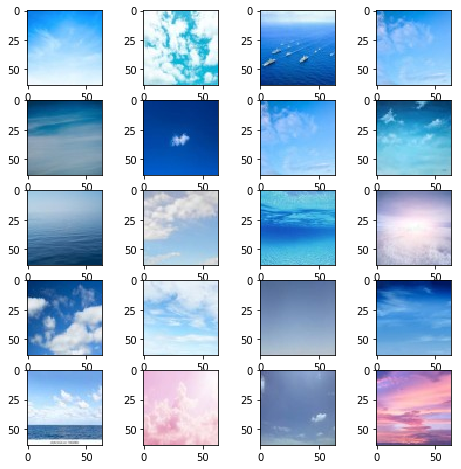

In [12]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train_c.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train_c[img_idx])
plt.show()

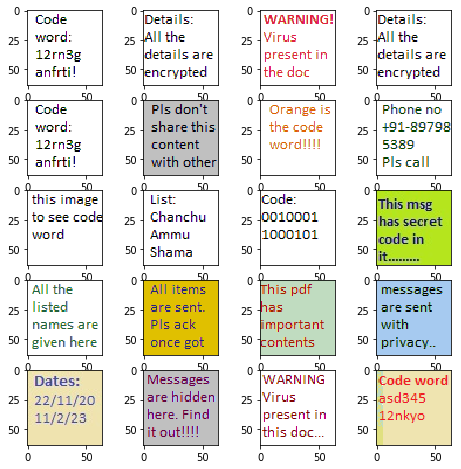

In [13]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train_s.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train_s[img_idx])
plt.show()

In [14]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
import tensorflow as tf
beta = 1.0
gamma = 0.5
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    rev_ssim = tf.image.ssim(s_true, s_pred, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
    rev_ssim_ = gamma*(1-rev_ssim)
    return (beta * K.sum(K.square(s_true - s_pred)))+rev_ssim_

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
    
    s_loss = rev_loss(s_true, s_pred)
    cover_ssim = tf.image.ssim(c_true, c_pred, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
    cover_ssim_ = gamma*(1 - cover_ssim)
    c_loss = K.sum(K.square(c_true - c_pred))+cover_ssim_
    
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    else:
        return Container(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    
    return encoder, decoder, autoencoder

In [15]:
 #makes model depending on the size of input_S array i.e secret image
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])

In [16]:
def lr_schedule(epoch_idx):
    if epoch_idx < 10:
        return 0.001
    elif epoch_idx < 20:
        return 0.0003
    elif epoch_idx < 30:
        return 0.0001
    else:
        return 0.00003

In [17]:
NB_EPOCHS = 50
BATCH_SIZE = 32

m = input_S.shape[0]
loss_history = []
for epoch in range(NB_EPOCHS):
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss = []
    for idx in t:
        
        batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                   y=np.concatenate((batch_S, batch_C),axis=3)))
        rev_loss.append(reveal_model.train_on_batch(x=C_prime,
                                              y=batch_S)) 
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
    loss_history.append(np.mean(ae_loss))

  0%|                                                                                           | 0/32 [00:00<?, ?it/s]E:\App\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
Epoch 1 | Batch:   0 of 1000. Loss AE  447853.44 | Loss Rev  308165.66:   3%|▎          | 1/32 [00:28<14:34, 28.19s/it]E:\App\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
Epoch 1 | Batch: 992 of 1000. Loss AE  246641.48 | Loss Rev  132530.44: 100%|██████████| 32/32 [12:10<00:00, 20.50s/it]
Epoch 2 | Batch: 992 of 1000. Loss AE   70262.61 | Loss Rev   24378.19: 100%|██████████| 32/

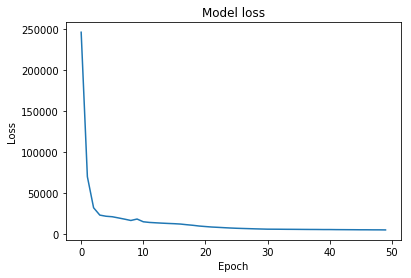

In [18]:
# Plot loss through epochs
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [19]:
# Retrieve decoded predictions.
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C)

In [20]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_Spixel, see_Cpixel

def pixel_histogram(diff_S, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,2,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, density=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(255* diff_Sflat, 100, density=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image.')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()

In [21]:
import math
def psnr(input_S, input_C, decoded_S, decoded_C):
    mse_s = np.mean(np.square(255*(input_S - decoded_S)))
    mse_c = np.mean(np.square(255*(input_C - decoded_C)))
    psnr_s = 10*math.log10(255**2/mse_s)
    psnr_c = 10*math.log10(255**2/mse_c)
    return psnr_s, psnr_c

In [22]:
# Print pixel-wise average errors in a 256 scale.
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 25.061182
C error per pixel [0, 255]: 15.728775


In [23]:
S_psnr, C_psnr = psnr(input_S, input_C, decoded_S, decoded_C)
print ("PSNR of secret and decoded secret:", S_psnr)
print ("PSNR of cover and container:", C_psnr)

PSNR of secret and decoded secret: 20.150772440701445
PSNR of cover and container: 24.196905335770825


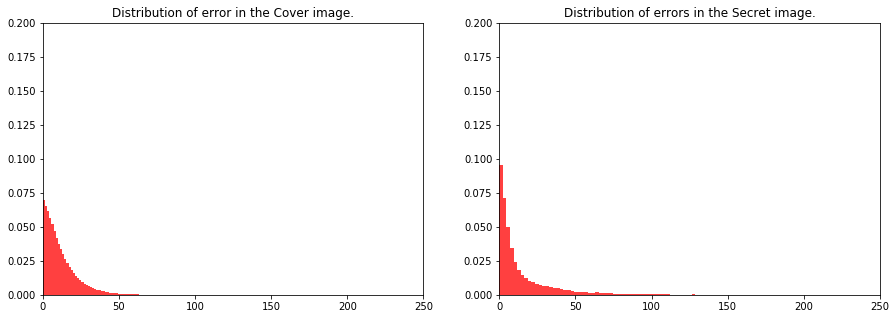

In [24]:
# Plot distribution of errors in cover and secret images.
pixel_histogram(diff_S, diff_C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


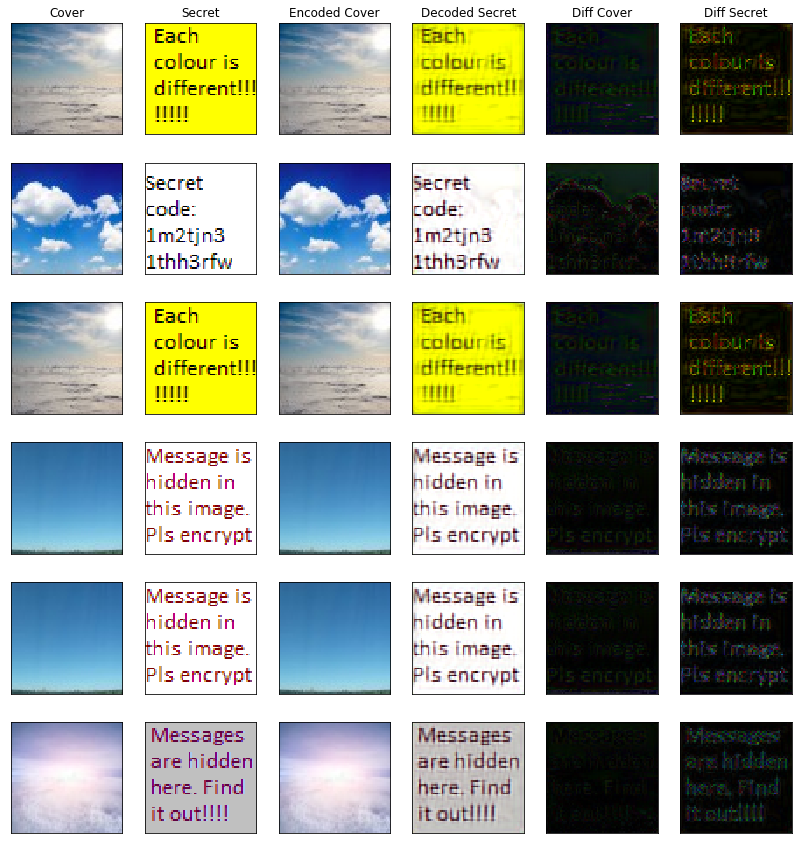

In [27]:

# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 15) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')

    
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()

In [23]:
def histogram_steganalysis(i):
    a = 255*input_C[i]
    a1 = a.flatten()
    b = 255*decoded_C[i] 
    b1 = b.flatten()
    fig = plt.figure(figsize=(10, 3))
    a=fig.add_subplot(1,2,1)
    imgplot = plt.hist(a1, bins = 256, facecolor='orange')
    a.set_title('Histogram of Cover image.')
    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(b1, bins = 256, facecolor='orange')
    a.set_title('Histogram of Container image.')
    plt.show()

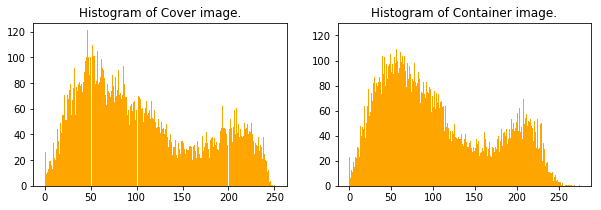

In [32]:
histogram_steganalysis(189)

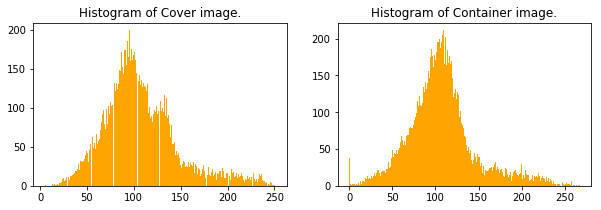

In [39]:
histogram_steganalysis(458)

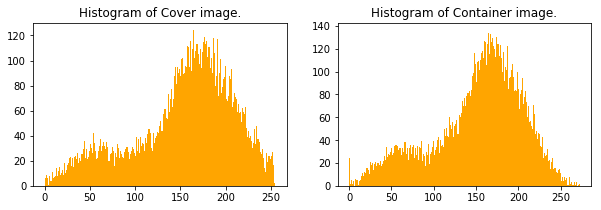

In [45]:
histogram_steganalysis(18)

In [60]:
from scipy.stats import norm
from statistics import *
import numpy as np
import matplotlib.pyplot as plt
def statistical_steganalysis(image_no):
    inp_C1 = rgb2gray(input_C[image_no])
    inp_C = np.pad(inp_C1, 1, mode='constant')
    print(inp_C.shape)
    cont1 = rgb2gray(decoded_C[image_no])
    cont = np.pad(cont1, 1, mode='constant')
    print(cont.shape)
    matrix_inp = []
    matrix_cont = []
    diff_values_inp = []
    diff_values_cont = []
    width, height = inp_C.shape
    for x in range(1, width-1):
        for y in range(1, height-1):
            for a in range(0,3):
                for b in range(0,3):
                    n = a+x-1
                    m = b+y-1
                    val_inp = inp_C[n][m]
                    val_cont = cont[n][m]
                    matrix_inp.append(val_inp)
                    matrix_cont.append(val_cont)
            I_inp = matrix_inp[4]
            mean_inp = (sum(matrix_inp)-I_inp) / (len(matrix_inp)-1)
            diff_inp = I_inp - mean_inp
            diff_values_inp.append(diff_inp)
            diff_v_inp = sorted(diff_values_inp)
            I_cont = matrix_cont[4]
            mean_cont = (sum(matrix_cont)-I_cont) / (len(matrix_cont)-1)
            diff_cont = I_cont - mean_cont
            diff_values_cont.append(diff_cont)
            diff_v_cont = sorted(diff_values_cont)
            matrix_inp = []
            matrix_cont = []
            
    def normal_dist(x , mean , sd):
        prob_density = (np.pi*sd) * np.exp(-0.5*((x-mean)/sd)**2)
        return prob_density
    #Calculate mean and Standard deviation.
    mean_i = np.mean(diff_v_inp)
    print("Mean of Cover image",mean_i)
    sd_i = np.std(diff_v_inp)
    print("Standard Deviation of Cover image",sd_i)
    variance_i = variance(diff_v_inp)
    print("Variance of Cover image",variance_i)
    
    mean_c = np.mean(diff_v_cont)
    print("Mean of Container image",mean_c)
    sd_c = np.std(diff_v_cont)
    print("Standard Deviation of Container image",sd_c)
    variance_c = variance(diff_v_cont)
    print("Variance of Container image",variance_c)
    
    pdf_i = normal_dist(diff_v_inp,mean_i,sd_i)
    pdf_c = normal_dist(diff_v_cont,mean_c,sd_c)
    
    fig = plt.figure(figsize=(10, 3))
    a=fig.add_subplot(1,2,1)
    imgplot = plt.plot(diff_v_inp,pdf_i , color = 'red')
    a.set_title('Normal PDF plot of Cover image.')
    
    a=fig.add_subplot(1,2,2)
    imgplot = plt.plot(diff_v_cont,pdf_c , color = 'red')
    a.set_title('Normal PDF plot of Container image.')
    plt.show()
    #print(diff_values)

(66, 66)
(66, 66)
Mean of Cover image 0.010107483420449741
Standard Deviation of Cover image 0.06366617402543488
Variance of Cover image 0.004054371551841608
Mean of Container image 0.009742527953598933
Standard Deviation of Container image 0.058866046131595566
Variance of Container image 0.0034660575926340888


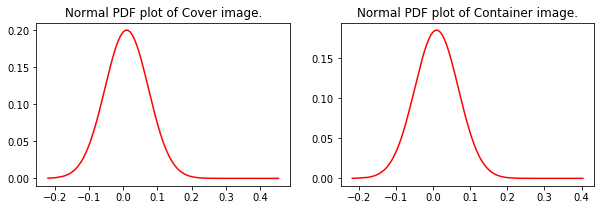

In [69]:
statistical_steganalysis(1)

(66, 66)
(66, 66)
Mean of Cover image 0.015030711791232535
Standard Deviation of Cover image 0.08489198211295586
Variance of Cover image 0.007208408492421013
Mean of Container image 0.015061083911285206
Standard Deviation of Container image 0.08071089425649362
Variance of Container image 0.006515839232745578


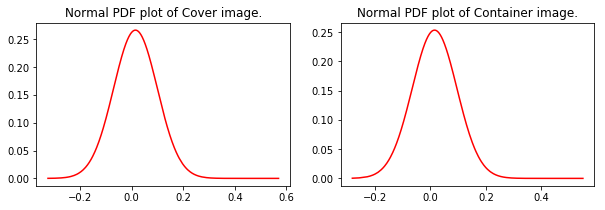

In [71]:
statistical_steganalysis(4)

(66, 66)
(66, 66)
Mean of Cover image 0.0068084548898037275
Standard Deviation of Cover image 0.05065629047706139
Variance of Cover image 0.0025666863973176405
Mean of Container image 0.0073630434931444555
Standard Deviation of Container image 0.046404150065868795
Variance of Container image 0.002153870990745521


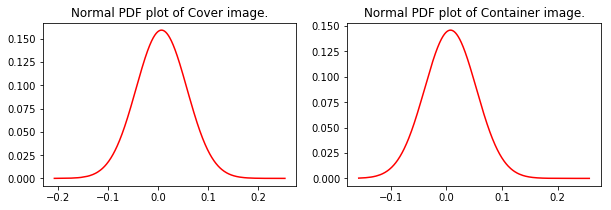

In [72]:
statistical_steganalysis(3)